In [ ]:
!pip install segmentation-models-pytorch

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
# for dirname, _, filenames in os.walk('/home/jupyter/data'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
from pathlib import Path

from tqdm.notebook import tqdm

import sys, os, random, time
import numba, cv2, gc
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

from segmentation_models_pytorch.unetplusplus import UnetPlusPlus
from segmentation_models_pytorch.unet import Unet
import segmentation_models_pytorch as smp

import rasterio
from rasterio.windows import Window

import albumentations as A

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def set_seeds(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seeds()

### Setup training variables

In [4]:
DATA_PATH = Path('/home/jupyter/data/')
assert DATA_PATH.exists()

In [5]:
def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    splits = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (splits[0:][::2], splits[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype='uint8')
    for lo, hi in zip(starts, ends):
        img[lo: hi] = 1
    return img.reshape(shape, order='F') # Fortran order reshaping

In [6]:
@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: points.append(1)
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if len(points) % 2 == 0:
                points.append(i+1)
            else:
                points.append(i+1 - points[-1])
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

In [7]:
# Check run length encoding starting with 0
assert rle_numba([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]) == [2, 2, 5, 1, 7, 4, 12, 1]
# Check run length encoding starting with 0
assert rle_numba([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]) == [1, 3, 5, 1, 7, 4, 12, 1]

/opt/conda/lib/python3.7/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'pixels' of function 'rle_numba'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-6-313ecb27751d>", line 2:
@numba.njit()
def rle_numba(pixels):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [8]:
def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [9]:
train_df = pd.read_csv(DATA_PATH / 'train.csv', index_col=[0])
train_df

encoding
id                                                          
2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
0486052bb  101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c  7464094 14 7480273 41 7496453 67 7512632 82 75...
095bf7a1f  113430380 22 113468538 67 113506697 111 113544...
54f2eec69  124601765 36 124632133 109 124662536 147 12469...
1e2425f28  49453112 7 49479881 22 49506657 31 49533433 40...

In [10]:
MASK_PATH = Path('/home/jupyter/ds_cache')
!mkdir {MASK_PATH}

import shutil

def reset_mask_path():
    shutil.rmtree(MASK_PATH)

mkdir: cannot create directory ‘/home/jupyter/ds_cache’: File exists


### Dataset

In [11]:
THRESHOLD = 100

# identity = rasterio.Affine(1, 0, 0, 0, 1, 0)
identity = None
# normalize_transform = T.Normalize([0.625, 0.448, 0.688], [0.131, 0.177, 0.101])
# normalize_transform = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# normalize_transform = T.Normalize([0.65459856,0.48386562,0.69428385], [0.15167958,0.23584107,0.13146145])
normalize_transform = T.Normalize([0.6130, 0.4126, 0.6595], [0.1417, 0.2045, 0.1237])

def read_from_slice(dataset, x1, x2, y1, y2):
    image = dataset.read([1,2,3],
                    window=Window.from_slices((x1,x2),(y1,y2)))
    image = np.moveaxis(image, 0, -1)
    return image

class HubDataset(D.Dataset):
    def __init__(self, root_dir, transform, window=256, overlap=32, threshold = THRESHOLD):
        self.path = root_dir
        assert self.path.exists()
        self.overlap, self.window, self.transform, self.threshold = overlap, window, transform, threshold
        self.csv = pd.read_csv(self.path / 'train.csv', index_col=[0])
        self.build_slices()
        self.len = len(self.slices)
        # where do these numbers come from?
        # Better to calculate them to check if correct.
        self.as_tensor = T.Compose([
            T.ToTensor(),
            normalize_transform,
        ])
        
        
    def build_slices(self):
        self.masks = []; self.files = []; self.slices = []
        self.skipped = 0
        for i, filename in tqdm(enumerate(self.csv.index), total = len(self.csv)):
            filepath = self.path/'train'/f'{filename}.tiff'
            assert filepath.exists()
            self.files.append(filepath)
            with rasterio.open(filepath) as dataset:
                dataset_shape = dataset.shape
                self.masks.append(rle_decode(self.csv.loc[filename, 'encoding'], dataset_shape))
                slices = make_grid(dataset_shape, window = self.window, min_overlap = self.overlap)
                # Only including slices above a specific threshold
                # Note: we are potentially throwing away some data here
                for slc in slices:
                    x1, x2, y1, y2 = slc
                    if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold:
                        self.slices.append([i,x1,x2,y1,y2])
                    else:
                        self.skipped += 1
                        
                        
    def apply_transform(self, image, mask):
        augments = self.transform(image=image, mask=mask)
        image = self.as_tensor(augments['image'])
        mask = augments['mask'][None]
        return image, mask
        
    def __getitem__(self, index):
        image_path = MASK_PATH/f'image_{index}'
        mask_path = MASK_PATH/f'mask_{index}'
        if not image_path.exists():
            idx = self.slices[index][0]
            filename = self.files[idx]
            x1, x2, y1, y2 = self.slices[index][1:]
            with rasterio.open(filename) as dataset:
                image = read_from_slice(dataset, x1, x2, y1, y2)
            mask = self.masks[idx][x1:x2,y1:y2]
            with open(image_path, "wb") as filehandler:
                pickle.dump(image, filehandler)
                if index % 100 == 0:
                    print(f'Writing to {image_path}')
            with open(mask_path, "wb") as filehandler:
                pickle.dump(mask, filehandler)
            return self.apply_transform(image, mask)
        else:
            with open(image_path,'rb') as file:
                image = pickle.load(file)
            with open(mask_path,'rb') as file:
                mask = pickle.load(file)
            return self.apply_transform(image, mask)
    
    def __len__(self):
        return self.len
    
    def __repr__(self):
        return f'total: {len(self)}, skipped: {self.skipped}'

In [12]:
WINDOW=1024
MIN_OVERLAP=32
NEW_SIZE=256

def generate_ds(size):
    trfm = A.Compose([
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ColorJitter (brightness=0.07, contrast=0.07,
                       saturation=0.1, hue=0.1, always_apply=False, p=0.3),
        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
                A.RandomBrightness(p=1)
            ],
            p=0.5,
        )
    ])

    return HubDataset(DATA_PATH, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm)

ds = generate_ds(NEW_SIZE)

  0%|          | 0/8 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [13]:
reset_mask_path()

In [14]:
!mkdir {MASK_PATH}

In [15]:
ds

total: 1771, skipped: 5735

(1024, 1024, 3)


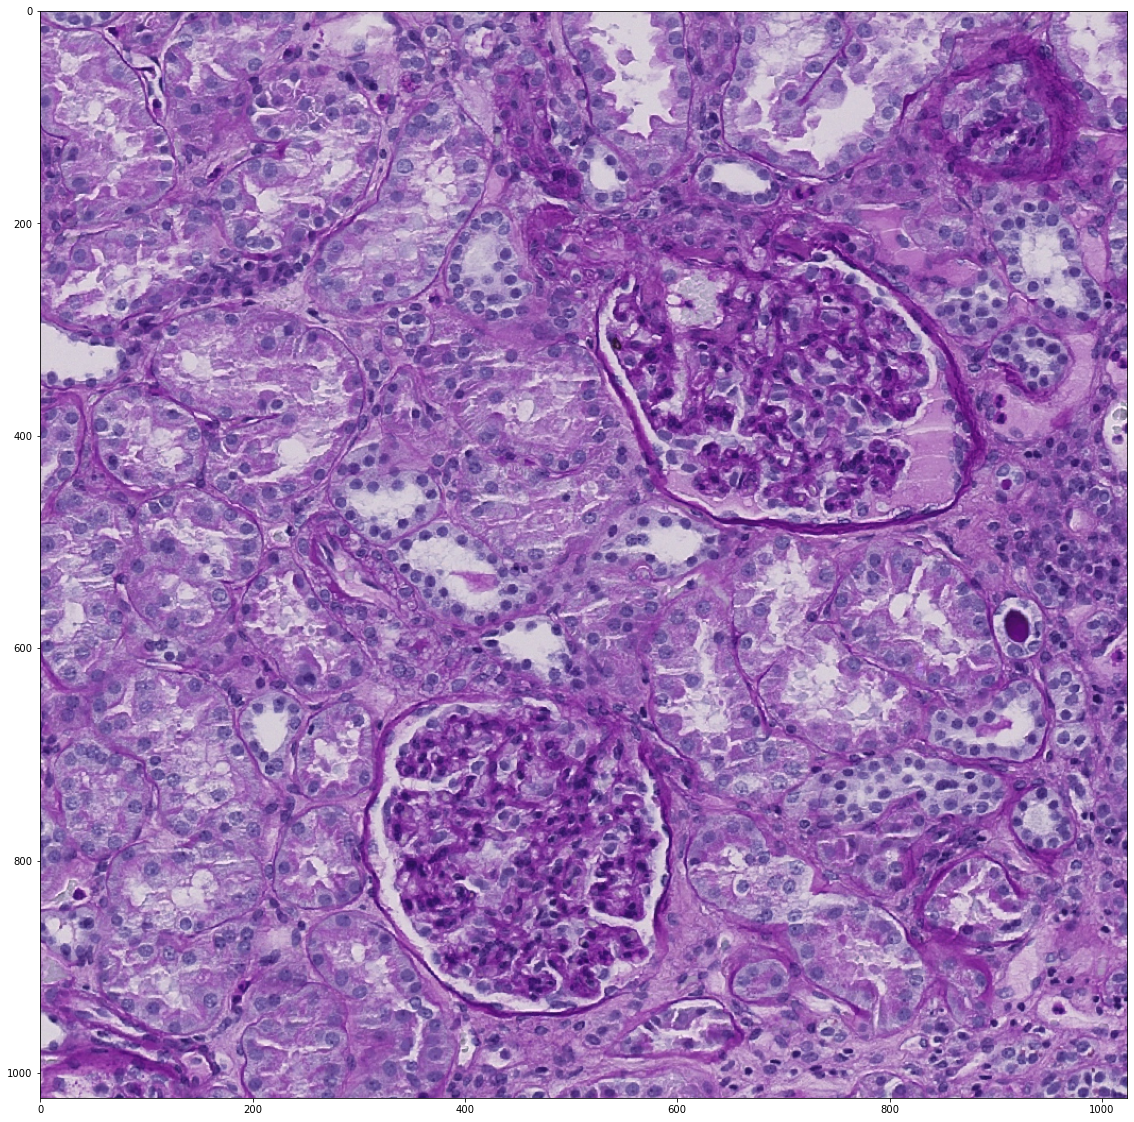

In [16]:
with rasterio.open('/home/jupyter/data/train/2f6ecfcdf.tiff') as raster:
    img = raster.read([1,2,3], window=Window.from_slices((3909, 4933),(11464,12488)))
    img = np.moveaxis(img, 0, -1)
    print(img.shape)
    crs = raster.crs

plt.figure(figsize = (20,20))
plt.imshow(img)
plt.show()


Writing to /home/jupyter/ds_cache/image_0


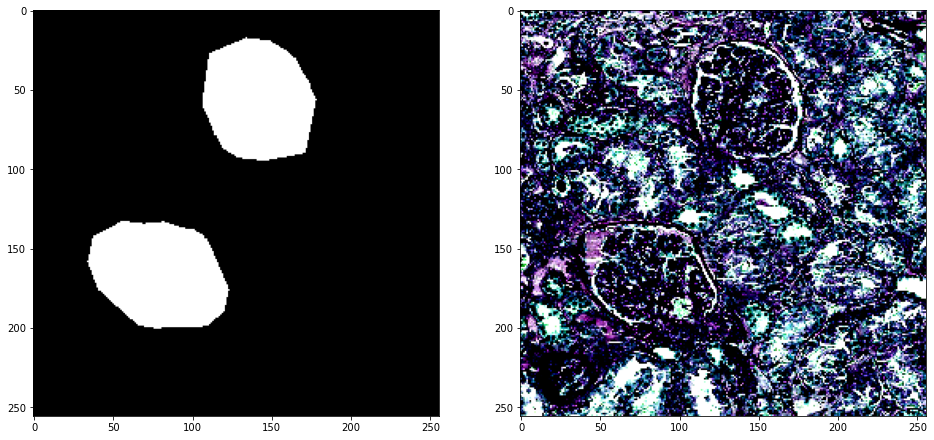

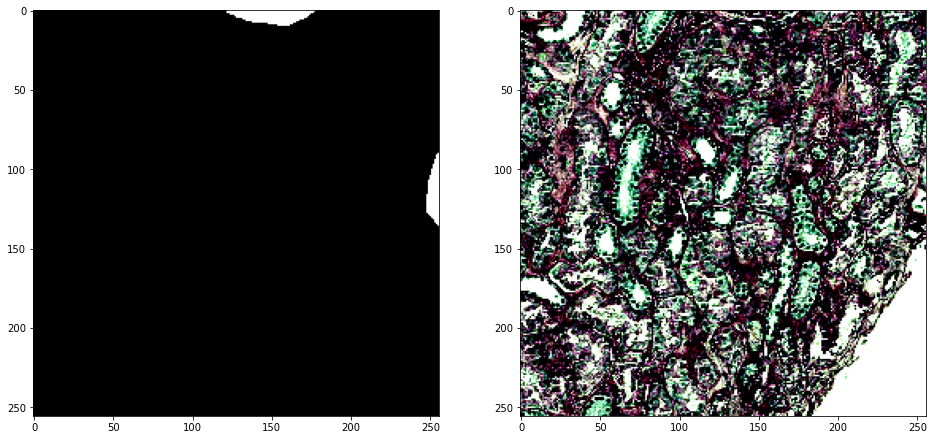

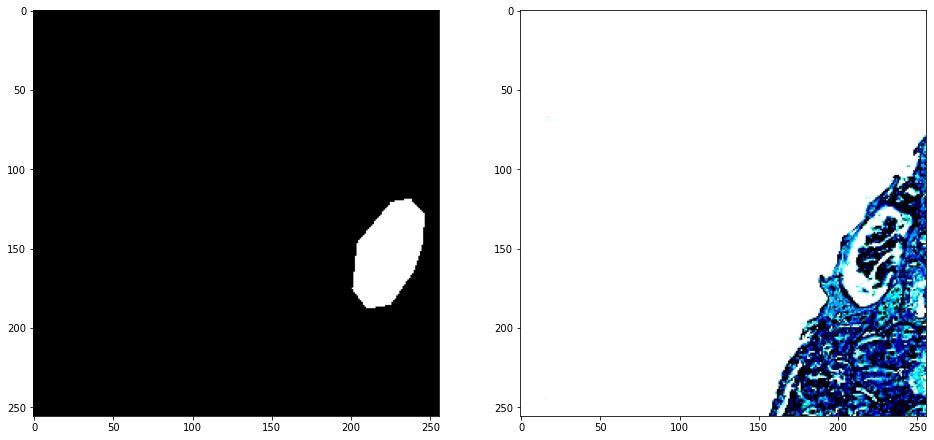

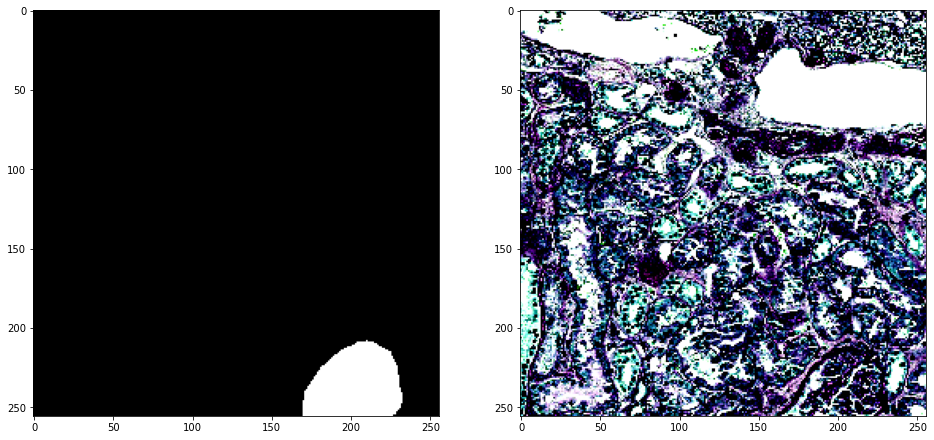

In [17]:
def display_mask_img(idx):
    image, mask = ds[idx]
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.imshow(mask[0], cmap='gray')
    plt.subplot(122)
    plt.imshow(np.moveaxis(image.numpy(), 0, -1));

display_mask_img(2)
display_mask_img(1)
display_mask_img(0)
display_mask_img(3)

In [18]:
image, mask = ds[2]

_ = rle_numba_encode(mask[0]) # compile function with numba

#### Split

In [19]:
def create_split_on_index(img_index = 7):
    valid_idx, train_idx = [], []
    for i in range(len(ds)):
        if ds.slices[i][0] == img_index:
            valid_idx.append(i)
        else:
            train_idx.append(i)
    return valid_idx, train_idx

#### Data loaders

In [20]:
BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
def generate_train_valid_dls(ds, train_idx, valid_idx):
    train_ds = D.Subset(ds, train_idx)
    valid_ds = D.Subset(ds, valid_idx)

    # define training and validation data loaders
    train_dl = D.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

    valid_dl = D.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    return train_dl, valid_dl

### Model

In [22]:
ENCODER_NAME = 'se_resnext50_32x4d'

class HuBMAPModel(nn.Module):
    def __init__(self):
        super(HuBMAPModel, self).__init__()
        self.model = Unet(encoder_name = ENCODER_NAME, 
                          encoder_weights = 'imagenet',
                          classes = 1,
                          activation = None)
        
        
    def forward(self, images):
        img_masks = self.model(images)
        return img_masks

In [23]:
def get_model():
    model = HuBMAPModel()
    return model

### Training

In [24]:
LR = 1e-3
WD = 1e-3
BEST_MODEL = 'best_model_unet_resnext.pth'

In [25]:
def create_optimizer_scheduler(model, train_dl, epochs):
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                    steps_per_epoch=len(train_dl), epochs=epochs)
    return optimizer, scheduler

### Loss

In [26]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):

        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.5 * bce + 0.5 * dice

In [27]:
# dice_loss = smp.utils.losses.DiceLoss()

# def loss_fn(y_pred, y_true):
#     return dice_loss(y_pred.sigmoid(), y_true)

In [28]:
def dice_metric(y_pred, y, epsilon = 1.0):
    dims=(-2,-1)
    x = (y_pred > 0).float()
    dc = (2 * (x * y).sum(dims) + epsilon) / ((x + y).sum(dims) + epsilon)
    return dc.mean()

In [29]:
iou_metric = smp.utils.metrics.IoU(threshold=0.5)

In [30]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_epoch(model, dataloader, optim, criterion, scheduler, device="cpu"):
    model.train()
    
    train_loss = []
    labels = []
    outs = []
    lrs = []
    
    tbar = tqdm(dataloader)
    scaler = torch.cuda.amp.GradScaler() # mixed precision support
    for step, (image, target) in enumerate(tbar):
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        
        optim.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(image)
            loss = criterion(output, target)
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        scaler.step(optim)
        scale = scaler.get_scale()
        scaler.update()
        skip_lr_sched = (scale != scaler.get_scale())
        if not skip_lr_sched:
            scheduler.step()
        
        train_loss.append(loss.item())
        lrs.append(get_lr(optim))
        
        tbar.set_description('loss - {:.4f}'.format(loss))
        
    print(f'Train loss: {np.array(train_loss).mean()}')
    return train_loss, lrs

In [31]:
def val_epoch(model, dataloader, criterion, epoch, device="cpu"):
    model.eval()

    valid_loss = []
    num_corrects = 0
    num_total = 0
    labels = []
    outs = []
    dice_metrics = []
    iou_metrics = []

    for item in dataloader:
        image, target = item
        image, target = image.to(DEVICE), target.float().to(DEVICE)

        with torch.no_grad():
            output = model(image)
            loss = criterion(output, target)
            dice_metrics.append(dice_metric(output, target))
            iou_metrics.append(iou_metric(output, target))
        valid_loss.append(loss.item())

    avg_loss = np.array(valid_loss).mean()
    print(f'Epoch {epoch} - valid loss: {avg_loss}')
    dice_metrics = [x.item() for x in dice_metrics]
    iou_metrics = [x.item() for x in iou_metrics]
    dice_metric_mean = np.array(dice_metrics).mean()
    iou_metric_mean = np.array(iou_metrics).mean()
    return dice_metrics, valid_loss, dice_metric_mean, avg_loss, iou_metric_mean

In [32]:
def train(epochs, train_dl, valid_dl, optimizer, scheduler):
    best_loss = 100.0
    best_metric = 0
    train_losses = []
    valid_losses = []
    accumulated_lrs = []
    accumulated_dice_metrics = []

    for epoch in tqdm(range(epochs)):
        train_loss, lrs = train_epoch(model, train_dl, optimizer, loss_fn, scheduler, DEVICE)
        dice_metrics, valid_loss, dice_metric_mean, avg_loss, iou_metric_mean = val_epoch(model, valid_dl, loss_fn, epoch, DEVICE)
        train_losses += train_loss
        valid_losses.append(np.array(valid_loss).mean())
        accumulated_lrs += lrs
        accumulated_dice_metrics.append(np.array(dice_metrics).mean())
        if best_metric < iou_metric_mean:
            best_metric = iou_metric_mean
            print('Saving model')
            torch.save(model.state_dict(), BEST_MODEL)
        if best_loss > avg_loss:
            best_loss = avg_loss
        print(f'Epoch {epoch} - val best loss {best_loss} dice metric ({dice_metric_mean}) iou metric ({iou_metric_mean}).')
        
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [33]:
# reset_mask_path()
# !mkdir {MASK_PATH}

In [34]:
EPOCHS = 20

In [35]:
def train_split(split):
    global model
    model = get_model()
    model.to(DEVICE)
    valid_idx, train_idx = create_split_on_index(split)
    f'Proportions valid / train: {len(valid_idx) / len(train_idx)}'
    train_dl, valid_dl = generate_train_valid_dls(ds, train_idx, valid_idx)
    optimizer, scheduler = create_optimizer_scheduler(model, train_dl, EPOCHS)
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train(EPOCHS, train_dl, valid_dl, optimizer, scheduler)
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [36]:
def train_split_and_move(split):
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train_split(split)
    stats_df = pd.DataFrame({'train_losses': train_losses, 'accumulated_lrs': accumulated_lrs})
    stats_df[['train_losses']].plot()
    !mv {BEST_MODEL} {split}_{BEST_MODEL}

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.6834357393284639
Writing to /home/jupyter/ds_cache/image_1600
Writing to /home/jupyter/ds_cache/image_1700
Epoch 0 - valid loss: 0.785893939435482
Saving model
Epoch 0 - val best loss 0.785893939435482 dice metric (0.31087179109454155) iou metric (0.29060644656419754).


  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.5233449842780828
Epoch 1 - valid loss: 0.4541272670030594
Saving model
Epoch 1 - val best loss 0.4541272670030594 dice metric (0.6534313261508942) iou metric (0.62226876989007).


  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.35154180725415546
Epoch 2 - valid loss: 0.3008551225066185
Saving model
Epoch 2 - val best loss 0.3008551225066185 dice metric (0.6997490152716637) iou metric (0.7043656632304192).


  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.21682843069235483
Epoch 3 - valid loss: 0.20920942537486553
Saving model
Epoch 3 - val best loss 0.20920942537486553 dice metric (0.740976944565773) iou metric (0.7356090396642685).


  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.15478044329211116
Epoch 4 - valid loss: 0.18224641401320696
Saving model
Epoch 4 - val best loss 0.18224641401320696 dice metric (0.7477419748902321) iou metric (0.7590033411979675).


  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.13993845460936427
Epoch 5 - valid loss: 0.17539300303906202
Epoch 5 - val best loss 0.17539300303906202 dice metric (0.7466415390372276) iou metric (0.7623244449496269).


  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.13000244150559107
Epoch 6 - valid loss: 0.18309582397341728
Epoch 6 - val best loss 0.17539300303906202 dice metric (0.7399912625551224) iou metric (0.7421224862337112).


  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.12369027935589354
Epoch 7 - valid loss: 0.15916801244020462
Saving model
Epoch 7 - val best loss 0.15916801244020462 dice metric (0.7727430984377861) iou metric (0.7807004079222679).


  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.11788511586685975
Epoch 8 - valid loss: 0.17939705215394497
Epoch 8 - val best loss 0.15916801244020462 dice metric (0.7437526360154152) iou metric (0.7613257095217705).


  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.11311845791836579
Epoch 9 - valid loss: 0.16541423089802265
Epoch 9 - val best loss 0.15916801244020462 dice metric (0.7657897546887398) iou metric (0.7617785930633545).


  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.10642073303461075
Epoch 10 - valid loss: 0.14543775655329227
Saving model
Epoch 10 - val best loss 0.14543775655329227 dice metric (0.7888745591044426) iou metric (0.7970028072595596).


  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.10313364770263433
Epoch 11 - valid loss: 0.15127111598849297
Epoch 11 - val best loss 0.14543775655329227 dice metric (0.7790133878588676) iou metric (0.8005222305655479).


  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.09680526292261978
Epoch 12 - valid loss: 0.147703655064106
Epoch 12 - val best loss 0.14543775655329227 dice metric (0.7843122035264969) iou metric (0.8012682795524597).


  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.09457552324359615
Epoch 13 - valid loss: 0.14559050649404526
Saving model
Epoch 13 - val best loss 0.14543775655329227 dice metric (0.7902257144451141) iou metric (0.7955702543258667).


  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.08785528806038201
Epoch 14 - valid loss: 0.14610847178846598
Epoch 14 - val best loss 0.14543775655329227 dice metric (0.7870274856686592) iou metric (0.8009444326162338).


  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.0841272584317873
Epoch 15 - valid loss: 0.14878350589424372
Epoch 15 - val best loss 0.14543775655329227 dice metric (0.7840066328644753) iou metric (0.7975093796849251).


  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.08311057610747714
Epoch 16 - valid loss: 0.14807987865060568
Epoch 16 - val best loss 0.14543775655329227 dice metric (0.7839134112000465) iou metric (0.7957016751170158).


  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.07929862197488546
Epoch 17 - valid loss: 0.14013429079204798
Saving model
Epoch 17 - val best loss 0.14013429079204798 dice metric (0.80177853256464) iou metric (0.8060102835297585).


  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.07780111324973404
Epoch 18 - valid loss: 0.14083183463662863
Epoch 18 - val best loss 0.14013429079204798 dice metric (0.7980368584394455) iou metric (0.8038400709629059).


  0%|          | 0/48 [00:00<?, ?it/s]

Train loss: 0.07743193628266454
Epoch 19 - valid loss: 0.14282628893852234
Epoch 19 - val best loss 0.14013429079204798 dice metric (0.7982229292392731) iou metric (0.8076559603214264).


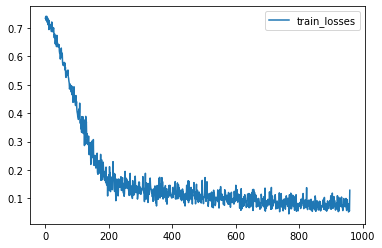

In [56]:
train_split_and_move(7)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.6897709194351646
Epoch 0 - valid loss: 0.6841945171356201
Saving model
Epoch 0 - val best loss 0.6841945171356201 dice metric (0.2026132971048355) iou metric (0.13977451324462892).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.5575871549400628
Epoch 1 - valid loss: 0.46413561701774597
Saving model
Epoch 1 - val best loss 0.46413561701774597 dice metric (0.6291943788528442) iou metric (0.6154714584350586).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.3640519386413051
Epoch 2 - valid loss: 0.2755772352218628
Saving model
Epoch 2 - val best loss 0.2755772352218628 dice metric (0.7557329773902893) iou metric (0.722046971321106).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.21746454694691827
Epoch 3 - valid loss: 0.173631951212883
Saving model
Epoch 3 - val best loss 0.173631951212883 dice metric (0.7905922174453736) iou metric (0.7633647322654724).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.15987869293666354
Epoch 4 - valid loss: 0.13083403259515763
Saving model
Epoch 4 - val best loss 0.13083403259515763 dice metric (0.8220057010650634) iou metric (0.7812847018241882).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.1421851594658459
Epoch 5 - valid loss: 0.13764302730560302
Epoch 5 - val best loss 0.13083403259515763 dice metric (0.8026677131652832) iou metric (0.782098400592804).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.13400569572752596
Epoch 6 - valid loss: 0.14398856610059738
Epoch 6 - val best loss 0.13083403259515763 dice metric (0.7959496378898621) iou metric (0.7638059258460999).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.13325396954428917
Epoch 7 - valid loss: 0.1278493657708168
Epoch 7 - val best loss 0.1278493657708168 dice metric (0.8139488935470581) iou metric (0.7866511106491089).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.12271985879131392
Epoch 8 - valid loss: 0.12720651626586915
Epoch 8 - val best loss 0.12720651626586915 dice metric (0.8120262265205384) iou metric (0.8143023252487183).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.11716235312176686
Epoch 9 - valid loss: 0.10398456752300263
Saving model
Epoch 9 - val best loss 0.10398456752300263 dice metric (0.8487207889556885) iou metric (0.8290555477142334).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.11494053491190367
Epoch 10 - valid loss: 0.12961147725582123
Epoch 10 - val best loss 0.10398456752300263 dice metric (0.8082260608673095) iou metric (0.7962491154670716).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.10745636987335541
Epoch 11 - valid loss: 0.12044156044721603
Epoch 11 - val best loss 0.10398456752300263 dice metric (0.8243981719017028) iou metric (0.8114099621772766).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.10270252794611688
Epoch 12 - valid loss: 0.11807873398065567
Epoch 12 - val best loss 0.10398456752300263 dice metric (0.8254548192024231) iou metric (0.813955295085907).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.09727532752588683
Epoch 13 - valid loss: 0.1088112935423851
Epoch 13 - val best loss 0.10398456752300263 dice metric (0.8440352797508239) iou metric (0.8134006500244141).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.09125676488175112
Epoch 14 - valid loss: 0.10677199363708496
Epoch 14 - val best loss 0.10398456752300263 dice metric (0.8447125554084778) iou metric (0.8272584438323974).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.08733752757018688
Epoch 15 - valid loss: 0.10423170179128646
Saving model
Epoch 15 - val best loss 0.10398456752300263 dice metric (0.849153745174408) iou metric (0.8263591527938843).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.083325001977238
Epoch 16 - valid loss: 0.10817280113697052
Epoch 16 - val best loss 0.10398456752300263 dice metric (0.8436020493507386) iou metric (0.8230018973350525).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.08169402583849196
Epoch 17 - valid loss: 0.10977171808481216
Epoch 17 - val best loss 0.10398456752300263 dice metric (0.8390332579612731) iou metric (0.8275500059127807).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.07926769963666505
Epoch 18 - valid loss: 0.10399871617555619
Saving model
Epoch 18 - val best loss 0.10398456752300263 dice metric (0.8497409105300904) iou metric (0.8307076811790466).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.07785085267296024
Epoch 19 - valid loss: 0.09866732358932495
Saving model
Epoch 19 - val best loss 0.09866732358932495 dice metric (0.8575592637062073) iou metric (0.8328247904777527).


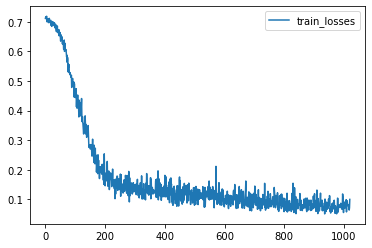

In [57]:
train_split_and_move(0)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.8411835150898628
Epoch 0 - valid loss: 1.2623740037282307
Saving model
Epoch 0 - val best loss 1.2623740037282307 dice metric (0.12184840937455495) iou metric (0.08150047560532887).


  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.6046935454854425
Epoch 1 - valid loss: 0.5960803826649984
Saving model
Epoch 1 - val best loss 0.5960803826649984 dice metric (0.45369454224904376) iou metric (0.403992493947347).


  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.3786048602383092
Epoch 2 - valid loss: 0.36404382189114887
Saving model
Epoch 2 - val best loss 0.36404382189114887 dice metric (0.6500795086224874) iou metric (0.5795763532320658).


  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.2214273860994375
Epoch 3 - valid loss: 0.22636074821154276
Saving model
Epoch 3 - val best loss 0.22636074821154276 dice metric (0.7302560806274414) iou metric (0.6883623600006104).


  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.1542070024418381
Epoch 4 - valid loss: 0.19614695012569427
Epoch 4 - val best loss 0.19614695012569427 dice metric (0.7216236193974813) iou metric (0.6704992254575094).


  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.13920419930287128
Epoch 5 - valid loss: 0.18026565512021384
Saving model
Epoch 5 - val best loss 0.18026565512021384 dice metric (0.7350162665049235) iou metric (0.6777209838231405).


  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.1296927290705015
Epoch 6 - valid loss: 0.20782402654488882
Epoch 6 - val best loss 0.18026565512021384 dice metric (0.7003590861956278) iou metric (0.6318426330884298).


  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.12130969987725312
Epoch 7 - valid loss: 0.17385600755612055
Saving model
Epoch 7 - val best loss 0.17385600755612055 dice metric (0.7396873831748962) iou metric (0.6783421436945597).


  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.11750472435411417
Epoch 8 - valid loss: 0.15403022865454355
Saving model
Epoch 8 - val best loss 0.15403022865454355 dice metric (0.7727468013763428) iou metric (0.7084688544273376).


  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.11352482944164637
Epoch 9 - valid loss: 0.14965303738911948
Saving model
Epoch 9 - val best loss 0.14965303738911948 dice metric (0.7855022549629211) iou metric (0.7077264984448751).


  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.10713774795239826
Epoch 10 - valid loss: 0.15834451218446097
Epoch 10 - val best loss 0.14965303738911948 dice metric (0.7691776156425476) iou metric (0.7092966834704081).


  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.10235609788939638
Epoch 11 - valid loss: 0.1559914549191793
Epoch 11 - val best loss 0.14965303738911948 dice metric (0.7696547110875448) iou metric (0.7247078021367391).


  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.09898376605420742
Epoch 12 - valid loss: 0.12933339923620224
Saving model
Epoch 12 - val best loss 0.12933339923620224 dice metric (0.8054716388384501) iou metric (0.7592286864916483).


  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.09172897631267332
Epoch 13 - valid loss: 0.1617994805177053
Epoch 13 - val best loss 0.12933339923620224 dice metric (0.7544346451759338) iou metric (0.7064169049263).


  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.08948007570403926
Epoch 14 - valid loss: 0.1343098779519399
Epoch 14 - val best loss 0.12933339923620224 dice metric (0.8010095159212748) iou metric (0.7533776958783468).


  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.08500098141859162
Epoch 15 - valid loss: 0.13083409269650778
Epoch 15 - val best loss 0.12933339923620224 dice metric (0.8047501444816589) iou metric (0.7575899759928385).


  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.08211097578113934
Epoch 16 - valid loss: 0.13799507915973663
Epoch 16 - val best loss 0.12933339923620224 dice metric (0.7957605322202047) iou metric (0.7461806337038676).


  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.07846824705319584
Epoch 17 - valid loss: 0.13997183243433634
Epoch 17 - val best loss 0.12933339923620224 dice metric (0.7906406919161478) iou metric (0.7413756251335144).


  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.07802823340555406
Epoch 18 - valid loss: 0.13087679694096246
Saving model
Epoch 18 - val best loss 0.12933339923620224 dice metric (0.8055163224538168) iou metric (0.7622125347455343).


  0%|          | 0/53 [00:00<?, ?it/s]

Train loss: 0.07662952494508815
Epoch 19 - valid loss: 0.1322723776102066
Epoch 19 - val best loss 0.12933339923620224 dice metric (0.8037571509679159) iou metric (0.7524774273236593).


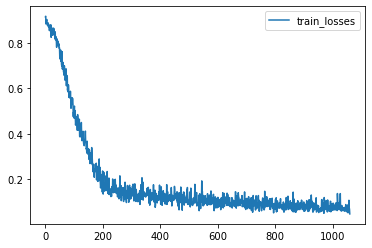

In [58]:
train_split_and_move(1)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.6693370860555897
Epoch 0 - valid loss: 0.6322372555732727
Saving model
Epoch 0 - val best loss 0.6322372555732727 dice metric (0.2725928303870288) iou metric (0.18314497714692896).


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.5257443941157797
Epoch 1 - valid loss: 0.40983102267438715
Saving model
Epoch 1 - val best loss 0.40983102267438715 dice metric (0.6802018068053506) iou metric (0.6666877974163402).


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.3545415382022443
Epoch 2 - valid loss: 0.2569197551770644
Saving model
Epoch 2 - val best loss 0.2569197551770644 dice metric (0.772424882108515) iou metric (0.7669401168823242).


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.21963076844163562
Epoch 3 - valid loss: 0.15690647607499902
Saving model
Epoch 3 - val best loss 0.15690647607499902 dice metric (0.8250767696987499) iou metric (0.8124693740497936).


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.16571647657648378
Epoch 4 - valid loss: 0.14083419062874533
Epoch 4 - val best loss 0.14083419062874533 dice metric (0.8143845796585083) iou metric (0.7978008877147328).


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.14296836997179882
Epoch 5 - valid loss: 0.14633387665856967
Epoch 5 - val best loss 0.14083419062874533 dice metric (0.8005235249345953) iou metric (0.7777362790974703).


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.1485491887382839
Epoch 6 - valid loss: 0.11202889545397325
Saving model
Epoch 6 - val best loss 0.11202889545397325 dice metric (0.842415988445282) iou metric (0.8387495116754011).


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.13067710755959802
Epoch 7 - valid loss: 0.10912356051531705
Saving model
Epoch 7 - val best loss 0.10912356051531705 dice metric (0.8499836488203569) iou metric (0.8398515365340493).


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.13039520237108934
Epoch 8 - valid loss: 0.12716960906982422
Epoch 8 - val best loss 0.10912356051531705 dice metric (0.8265595110979947) iou metric (0.8116107257929716).


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.1305781609338263
Epoch 9 - valid loss: 0.10837800936265425
Epoch 9 - val best loss 0.10837800936265425 dice metric (0.8472191908142783) iou metric (0.8353852196173235).


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.1202150751715121
Epoch 10 - valid loss: 0.10778180848468434
Epoch 10 - val best loss 0.10778180848468434 dice metric (0.8462411923841997) iou metric (0.8459501158107411).


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.10970645689445993
Epoch 11 - valid loss: 0.10157000747593967
Saving model
Epoch 11 - val best loss 0.10157000747593967 dice metric (0.858713383024389) iou metric (0.8476113785396923).


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.11859978265736414
Epoch 12 - valid loss: 0.0981603241102262
Saving model
Epoch 12 - val best loss 0.0981603241102262 dice metric (0.8607977791266008) iou metric (0.8571219823577187).


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.10540032662127329
Epoch 13 - valid loss: 0.09401674873449585
Saving model
Epoch 13 - val best loss 0.09401674873449585 dice metric (0.868369996547699) iou metric (0.8559174266728488).


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.09648172508763231
Epoch 14 - valid loss: 0.09185916354710405
Saving model
Epoch 14 - val best loss 0.09185916354710405 dice metric (0.8690651492639021) iou metric (0.8596975369886919).


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.09091652314300122
Epoch 15 - valid loss: 0.09915101799097928
Epoch 15 - val best loss 0.09185916354710405 dice metric (0.8584777225147594) iou metric (0.8559268333695151).


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.08859647494619308
Epoch 16 - valid loss: 0.09718219190835953
Epoch 16 - val best loss 0.09185916354710405 dice metric (0.8607891201972961) iou metric (0.8601019978523254).


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.0841569386260665
Epoch 17 - valid loss: 0.09253663840619
Epoch 17 - val best loss 0.09185916354710405 dice metric (0.8680694049054926) iou metric (0.86504742232236).


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.08854158020213894
Epoch 18 - valid loss: 0.09411050988869234
Epoch 18 - val best loss 0.09185916354710405 dice metric (0.8661467216231606) iou metric (0.8606360121206804).


  0%|          | 0/46 [00:00<?, ?it/s]

Train loss: 0.08270286987333195
Epoch 19 - valid loss: 0.10235711119391701
Epoch 19 - val best loss 0.09185916354710405 dice metric (0.8556155020540411) iou metric (0.8482338840311224).


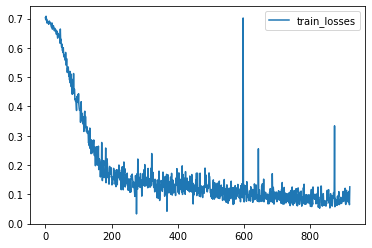

In [59]:
train_split_and_move(2)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.7834779207523053
Epoch 0 - valid loss: 0.7560267686843872
Saving model
Epoch 0 - val best loss 0.7560267686843872 dice metric (0.1976298213005066) iou metric (0.18558917343616485).


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.6075111398330102
Epoch 1 - valid loss: 0.5186693429946899
Saving model
Epoch 1 - val best loss 0.5186693429946899 dice metric (0.6425673484802246) iou metric (0.6638333976268769).


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.3921915923173611
Epoch 2 - valid loss: 0.28507825136184695
Saving model
Epoch 2 - val best loss 0.28507825136184695 dice metric (0.8107486367225647) iou metric (0.7960885167121887).


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.22954509865779144
Epoch 3 - valid loss: 0.15354812145233154
Saving model
Epoch 3 - val best loss 0.15354812145233154 dice metric (0.8437957882881164) iou metric (0.8228820919990539).


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.1657451865478204
Epoch 4 - valid loss: 0.1007849395275116
Saving model
Epoch 4 - val best loss 0.1007849395275116 dice metric (0.8782622575759887) iou metric (0.8573264718055725).


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.1477204757527663
Epoch 5 - valid loss: 0.09731827229261399
Epoch 5 - val best loss 0.09731827229261399 dice metric (0.8705568194389344) iou metric (0.854423725605011).


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.1380463159428193
Epoch 6 - valid loss: 0.08743906766176224
Saving model
Epoch 6 - val best loss 0.08743906766176224 dice metric (0.8846147656440735) iou metric (0.8554993629455566).


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.127860493098314
Epoch 7 - valid loss: 0.07877659946680068
Saving model
Epoch 7 - val best loss 0.07877659946680068 dice metric (0.889592957496643) iou metric (0.8686416864395141).


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.12373794271395756
Epoch 8 - valid loss: 0.08416135311126709
Epoch 8 - val best loss 0.07877659946680068 dice metric (0.8826608419418335) iou metric (0.8605798959732056).


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.11715591455308291
Epoch 9 - valid loss: 0.07787482738494873
Saving model
Epoch 9 - val best loss 0.07787482738494873 dice metric (0.8951786041259766) iou metric (0.8584577202796936).


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.1133241790991563
Epoch 10 - valid loss: 0.07348162159323693
Saving model
Epoch 10 - val best loss 0.07348162159323693 dice metric (0.8972707509994506) iou metric (0.870128870010376).


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.10802189776530632
Epoch 11 - valid loss: 0.06945492178201676
Saving model
Epoch 11 - val best loss 0.06945492178201676 dice metric (0.9047486186027527) iou metric (0.8730873703956604).


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.10375102767004417
Epoch 12 - valid loss: 0.07161733582615852
Epoch 12 - val best loss 0.06945492178201676 dice metric (0.9008588194847107) iou metric (0.867721164226532).


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.0960956089771711
Epoch 13 - valid loss: 0.06991682350635528
Epoch 13 - val best loss 0.06945492178201676 dice metric (0.9023215532302856) iou metric (0.8770249962806702).


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.09261481707485822
Epoch 14 - valid loss: 0.07119768485426903
Epoch 14 - val best loss 0.06945492178201676 dice metric (0.9009144902229309) iou metric (0.871511971950531).


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.08585403515742375
Epoch 15 - valid loss: 0.06513588279485702
Saving model
Epoch 15 - val best loss 0.06513588279485702 dice metric (0.910368275642395) iou metric (0.8818511128425598).


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.08671325982476656
Epoch 16 - valid loss: 0.0679895170032978
Epoch 16 - val best loss 0.06513588279485702 dice metric (0.9035213947296142) iou metric (0.8802694916725159).


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.0825103589405234
Epoch 17 - valid loss: 0.07241743505001068
Epoch 17 - val best loss 0.06513588279485702 dice metric (0.8947296142578125) iou metric (0.8755177974700927).


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.08145849807904317
Epoch 18 - valid loss: 0.06516669690608978
Epoch 18 - val best loss 0.06513588279485702 dice metric (0.9079728722572327) iou metric (0.8831876993179322).


  0%|          | 0/52 [00:00<?, ?it/s]

Train loss: 0.08046536426991224
Epoch 19 - valid loss: 0.06229426264762879
Saving model
Epoch 19 - val best loss 0.06229426264762879 dice metric (0.9140156149864197) iou metric (0.8874317526817321).


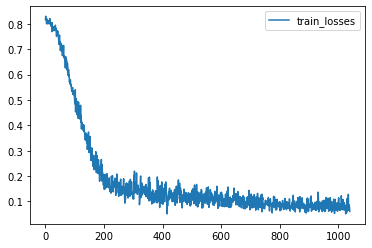

In [60]:
train_split_and_move(3)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.8921644383547257
Epoch 0 - valid loss: 0.8708201476505825
Saving model
Epoch 0 - val best loss 0.8708201476505825 dice metric (0.17333604182515824) iou metric (0.1293874074305807).


  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.7193975180995708
Epoch 1 - valid loss: 0.603147166115897
Saving model
Epoch 1 - val best loss 0.603147166115897 dice metric (0.5027298288685935) iou metric (0.5524435256208692).


  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.4531123449607771
Epoch 2 - valid loss: 0.3601967522076198
Saving model
Epoch 2 - val best loss 0.3601967522076198 dice metric (0.6990349633353097) iou metric (0.7041287251881191).


  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.25309119267123087
Epoch 3 - valid loss: 0.238324373960495
Saving model
Epoch 3 - val best loss 0.238324373960495 dice metric (0.7244334306035723) iou metric (0.7066763469151088).


  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.16420965945842314
Epoch 4 - valid loss: 0.19903195542948587
Saving model
Epoch 4 - val best loss 0.19903195542948587 dice metric (0.7360859768731254) iou metric (0.7171517269951957).


  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.14061084769818247
Epoch 5 - valid loss: 0.2052847146987915
Epoch 5 - val best loss 0.19903195542948587 dice metric (0.7269987038203648) iou metric (0.7105014749935695).


  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.13345682666617997
Epoch 6 - valid loss: 0.18165889595236098
Saving model
Epoch 6 - val best loss 0.18165889595236098 dice metric (0.7544160144669669) iou metric (0.7439950363976615).


  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.12507583565857947
Epoch 7 - valid loss: 0.188548315848623
Epoch 7 - val best loss 0.18165889595236098 dice metric (0.7446846536227635) iou metric (0.7274988719395229).


  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.11716049529460011
Epoch 8 - valid loss: 0.17699858333383287
Saving model
Epoch 8 - val best loss 0.17699858333383287 dice metric (0.7594538841928754) iou metric (0.7410110235214233).


  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.11329448876940475
Epoch 9 - valid loss: 0.16280404584748404
Saving model
Epoch 9 - val best loss 0.16280404584748404 dice metric (0.7716957671301705) iou metric (0.7703818082809448).


  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.10663273656854824
Epoch 10 - valid loss: 0.19451721438339778
Epoch 10 - val best loss 0.16280404584748404 dice metric (0.7267584119524274) iou metric (0.7269289749009269).


  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.10020903178623744
Epoch 11 - valid loss: 0.1706457393510001
Epoch 11 - val best loss 0.16280404584748404 dice metric (0.7691890852791923) iou metric (0.7547678606850761).


  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.09608208950684995
Epoch 12 - valid loss: 0.1663851078067507
Epoch 12 - val best loss 0.16280404584748404 dice metric (0.7687641041619437) iou metric (0.7628186004502433).


  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.0899471150977271
Epoch 13 - valid loss: 0.1636758063520704
Saving model
Epoch 13 - val best loss 0.16280404584748404 dice metric (0.7750505038670131) iou metric (0.7627884319850377).


  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.08805796063067961
Epoch 14 - valid loss: 0.17219726741313934
Epoch 14 - val best loss 0.16280404584748404 dice metric (0.7641809923308236) iou metric (0.7527358617101397).


  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.08331655254777597
Epoch 15 - valid loss: 0.16909728518554143
Epoch 15 - val best loss 0.16280404584748404 dice metric (0.7642421637262616) iou metric (0.7539632405553546).


  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.08104439285032604
Epoch 16 - valid loss: 0.1663657554558345
Epoch 16 - val best loss 0.16280404584748404 dice metric (0.7738225970949445) iou metric (0.7593095217432294).


  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.07661693185871961
Epoch 17 - valid loss: 0.16533821395465306
Epoch 17 - val best loss 0.16280404584748404 dice metric (0.7706736326217651) iou metric (0.7569805979728699).


  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.07451559359929999
Epoch 18 - valid loss: 0.16631396753447397
Epoch 18 - val best loss 0.16280404584748404 dice metric (0.7696026478494916) iou metric (0.7586815101759774).


  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.07563954705790597
Epoch 19 - valid loss: 0.15956160426139832
Saving model
Epoch 19 - val best loss 0.15956160426139832 dice metric (0.7817049537386213) iou metric (0.7596564037459237).


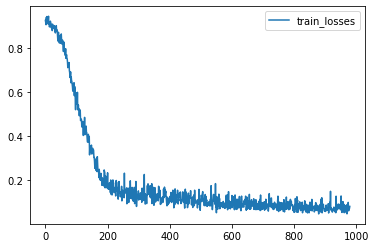

In [61]:
train_split_and_move(4)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.7768700406664893
Epoch 0 - valid loss: 0.7763765326568058
Saving model
Epoch 0 - val best loss 0.7763765326568058 dice metric (0.21354616646255767) iou metric (0.16019505581685475).


  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.6759808276380811
Epoch 1 - valid loss: 0.6236741840839386
Saving model
Epoch 1 - val best loss 0.6236741840839386 dice metric (0.45129467121192385) iou metric (0.42348185926675797).


  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.46622975667317706
Epoch 2 - valid loss: 0.3498584372656686
Saving model
Epoch 2 - val best loss 0.3498584372656686 dice metric (0.7160462098462241) iou metric (0.6926791965961456).


  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.28376066365412306
Epoch 3 - valid loss: 0.23168364592960902
Saving model
Epoch 3 - val best loss 0.23168364592960902 dice metric (0.7655961385795048) iou metric (0.730674262557711).


  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.17721995959679285
Epoch 4 - valid loss: 0.19692533676113402
Epoch 4 - val best loss 0.19692533676113402 dice metric (0.7596795729228428) iou metric (0.7021050410611289).


  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.14000020477743375
Epoch 5 - valid loss: 0.18779408931732178
Epoch 5 - val best loss 0.18779408931732178 dice metric (0.7539685581411634) iou metric (0.7266945115157536).


  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.12992807726065317
Epoch 6 - valid loss: 0.17943716049194336
Epoch 6 - val best loss 0.17943716049194336 dice metric (0.7587244042328426) iou metric (0.7370106748172215).


  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.12201099842786789
Epoch 7 - valid loss: 0.17511584609746933
Saving model
Epoch 7 - val best loss 0.17511584609746933 dice metric (0.7719429433345795) iou metric (0.7405916494982583).


  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.11416899040341377
Epoch 8 - valid loss: 0.1666076864515032
Saving model
Epoch 8 - val best loss 0.1666076864515032 dice metric (0.7793043979576656) iou metric (0.7507167160511017).


  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.10760622028084028
Epoch 9 - valid loss: 0.1595571722303118
Saving model
Epoch 9 - val best loss 0.1595571722303118 dice metric (0.7862906157970428) iou metric (0.7524883661951337).


  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.10340531312284015
Epoch 10 - valid loss: 0.16646393814257213
Epoch 10 - val best loss 0.1595571722303118 dice metric (0.7760684788227081) iou metric (0.7473226828234536).


  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.09913128224157151
Epoch 11 - valid loss: 0.16773567029408046
Epoch 11 - val best loss 0.1595571722303118 dice metric (0.7766140486512866) iou metric (0.7466140389442444).


  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.09471952977279822
Epoch 12 - valid loss: 0.16112326085567474
Epoch 12 - val best loss 0.1595571722303118 dice metric (0.7845318615436554) iou metric (0.7579099578516824).


  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.08938161984440826
Epoch 13 - valid loss: 0.15936348480837687
Saving model
Epoch 13 - val best loss 0.15936348480837687 dice metric (0.7883510334151131) iou metric (0.7587510475090572).


  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.08352418554325898
Epoch 14 - valid loss: 0.15499628388455935
Saving model
Epoch 14 - val best loss 0.15499628388455935 dice metric (0.7912692044462476) iou metric (0.7597008900982993).


  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.08293785642655123
Epoch 15 - valid loss: 0.15632664092949458
Saving model
Epoch 15 - val best loss 0.15499628388455935 dice metric (0.7924623574529376) iou metric (0.7613540036337716).


  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.07811151320735614
Epoch 16 - valid loss: 0.15726723042981966
Epoch 16 - val best loss 0.15499628388455935 dice metric (0.790615724665778) iou metric (0.7598786950111389).


  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.07667312886388529
Epoch 17 - valid loss: 0.15783937381846563
Epoch 17 - val best loss 0.15499628388455935 dice metric (0.792354302746909) iou metric (0.7589457418237414).


  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.07434040316868396
Epoch 18 - valid loss: 0.15636665746569633
Epoch 18 - val best loss 0.15499628388455935 dice metric (0.7918779977730342) iou metric (0.7630900400025504).


  0%|          | 0/42 [00:00<?, ?it/s]

Train loss: 0.07328338273579166
Epoch 19 - valid loss: 0.1576890189732824
Epoch 19 - val best loss 0.15499628388455935 dice metric (0.7912607448441642) iou metric (0.7589641809463501).


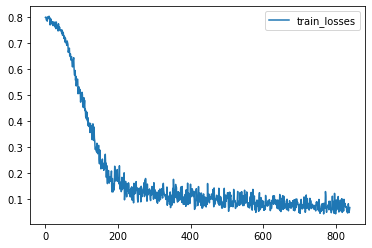

In [63]:
train_split_and_move(5)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Writing to /home/jupyter/ds_cache/image_800
Writing to /home/jupyter/ds_cache/image_1600
Writing to /home/jupyter/ds_cache/image_1300
Writing to /home/jupyter/ds_cache/image_200
Writing to /home/jupyter/ds_cache/image_500
Writing to /home/jupyter/ds_cache/image_1100
Writing to /home/jupyter/ds_cache/image_400
Writing to /home/jupyter/ds_cache/image_900
Writing to /home/jupyter/ds_cache/image_100
Writing to /home/jupyter/ds_cache/image_1700
Writing to /home/jupyter/ds_cache/image_1000
Writing to /home/jupyter/ds_cache/image_300
Writing to /home/jupyter/ds_cache/image_700
Writing to /home/jupyter/ds_cache/image_1200
Writing to /home/jupyter/ds_cache/image_600
Train loss: 0.83929295983969
Writing to /home/jupyter/ds_cache/image_1400
Writing to /home/jupyter/ds_cache/image_1500
Epoch 0 - valid loss: 0.7859339813391367
Saving model
Epoch 0 - val best loss 0.7859339813391367 dice metric (0.22260242948929468) iou metric (0.18932750324408212).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.6665059596884484
Epoch 1 - valid loss: 0.5076996286710104
Saving model
Epoch 1 - val best loss 0.5076996286710104 dice metric (0.6222995569308599) iou metric (0.6212099691232046).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.42885590943635676
Epoch 2 - valid loss: 0.3606821497281392
Saving model
Epoch 2 - val best loss 0.3606821497281392 dice metric (0.678259551525116) iou metric (0.6383351584275564).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.25424011431488336
Epoch 3 - valid loss: 0.25741315136353177
Saving model
Epoch 3 - val best loss 0.25741315136353177 dice metric (0.6956767588853836) iou metric (0.6719322999318441).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.1676213075132931
Epoch 4 - valid loss: 0.251266007622083
Epoch 4 - val best loss 0.251266007622083 dice metric (0.6489787499109904) iou metric (0.6506795088450114).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.14942162980635962
Epoch 5 - valid loss: 0.29572423299153644
Epoch 5 - val best loss 0.251266007622083 dice metric (0.620241234699885) iou metric (0.5613996535539627).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.13897760504601048
Epoch 6 - valid loss: 0.19016252209742865
Saving model
Epoch 6 - val best loss 0.19016252209742865 dice metric (0.7391733030478159) iou metric (0.7432123521963755).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.12551472102310143
Epoch 7 - valid loss: 0.21030614525079727
Epoch 7 - val best loss 0.19016252209742865 dice metric (0.6924941390752792) iou metric (0.7167228062947592).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.12383437405029933
Epoch 8 - valid loss: 0.1752388353149096
Saving model
Epoch 8 - val best loss 0.1752388353149096 dice metric (0.7491421898206075) iou metric (0.7445802787939707).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.11699909147094278
Epoch 9 - valid loss: 0.20466402173042297
Epoch 9 - val best loss 0.1752388353149096 dice metric (0.7132303714752197) iou metric (0.7208455602327982).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.110967069133824
Epoch 10 - valid loss: 0.1899160606165727
Epoch 10 - val best loss 0.1752388353149096 dice metric (0.7325331469376882) iou metric (0.7338346739610037).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.10330419724478442
Epoch 11 - valid loss: 0.1676239420970281
Saving model
Epoch 11 - val best loss 0.1676239420970281 dice metric (0.7642418841520945) iou metric (0.756338636080424).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.09821737857133735
Epoch 12 - valid loss: 0.18146955966949463
Epoch 12 - val best loss 0.1676239420970281 dice metric (0.7459413707256317) iou metric (0.7435782055060068).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.09264512878714823
Epoch 13 - valid loss: 0.21988119060794512
Epoch 13 - val best loss 0.1676239420970281 dice metric (0.6941897918780645) iou metric (0.7084774176279703).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.08996016678272509
Epoch 14 - valid loss: 0.18556091810266176
Epoch 14 - val best loss 0.1676239420970281 dice metric (0.7385196586449941) iou metric (0.7339562276999155).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.08547881136045736
Epoch 15 - valid loss: 0.1850984419385592
Epoch 15 - val best loss 0.1676239420970281 dice metric (0.7373343954483668) iou metric (0.7352856894334158).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.08176723268686556
Epoch 16 - valid loss: 0.1919174107412497
Epoch 16 - val best loss 0.1676239420970281 dice metric (0.718977356950442) iou metric (0.7406982680161794).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.07934373441864462
Epoch 17 - valid loss: 0.1767508847018083
Epoch 17 - val best loss 0.1676239420970281 dice metric (0.7617458403110504) iou metric (0.7429158190886179).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.08095501560498686
Epoch 18 - valid loss: 0.19321391234795252
Epoch 18 - val best loss 0.1676239420970281 dice metric (0.7347379922866821) iou metric (0.7332507371902466).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.07969007100544724
Epoch 19 - valid loss: 0.18036576360464096
Epoch 19 - val best loss 0.1676239420970281 dice metric (0.7468342085679373) iou metric (0.7430296142896017).


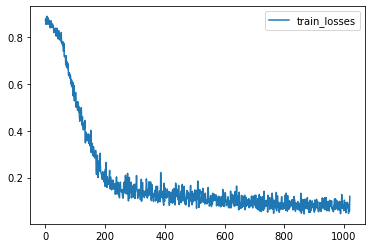

In [44]:
train_split_and_move(6)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Writing to /home/jupyter/ds_cache/image_100
Writing to /home/jupyter/ds_cache/image_200
Writing to /home/jupyter/ds_cache/image_1100
Writing to /home/jupyter/ds_cache/image_500
Writing to /home/jupyter/ds_cache/image_600
Writing to /home/jupyter/ds_cache/image_400
Writing to /home/jupyter/ds_cache/image_1700
Writing to /home/jupyter/ds_cache/image_1200
Writing to /home/jupyter/ds_cache/image_800
Writing to /home/jupyter/ds_cache/image_700
Writing to /home/jupyter/ds_cache/image_900
Writing to /home/jupyter/ds_cache/image_300
Writing to /home/jupyter/ds_cache/image_1600
Writing to /home/jupyter/ds_cache/image_1300
Writing to /home/jupyter/ds_cache/image_1000
Train loss: 0.8401005034353218
Writing to /home/jupyter/ds_cache/image_1400
Writing to /home/jupyter/ds_cache/image_1500
Epoch 0 - valid loss: 0.7935136059919993
Saving model
Epoch 0 - val best loss 0.7935136059919993 dice metric (0.21593247850735983) iou metric (0.1823158636689186).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.6735546214907777
Epoch 1 - valid loss: 0.5128562947114309
Saving model
Epoch 1 - val best loss 0.5128562947114309 dice metric (0.6280737717946371) iou metric (0.6264663139979044).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.43175412159340054
Epoch 2 - valid loss: 0.3531089276075363
Saving model
Epoch 2 - val best loss 0.3531089276075363 dice metric (0.67475659151872) iou metric (0.6528589328130087).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.2515536648970024
Epoch 3 - valid loss: 0.2470302109917005
Saving model
Epoch 3 - val best loss 0.2470302109917005 dice metric (0.706776887178421) iou metric (0.6761907537778219).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.16929399894148695
Epoch 4 - valid loss: 0.26352382948001224
Epoch 4 - val best loss 0.2470302109917005 dice metric (0.6563057700792948) iou metric (0.6153356929620107).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.14117273702925326
Epoch 5 - valid loss: 0.19618859142065048
Saving model
Epoch 5 - val best loss 0.19618859142065048 dice metric (0.7295597592989603) iou metric (0.7127561668554941).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.13122487754798404
Epoch 6 - valid loss: 0.21976909041404724
Epoch 6 - val best loss 0.19618859142065048 dice metric (0.6791950960954031) iou metric (0.7109207510948181).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.1233857209775962
Epoch 7 - valid loss: 0.2526865576704343
Epoch 7 - val best loss 0.19618859142065048 dice metric (0.6467712074518204) iou metric (0.6449272384246191).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.12219869360035542
Epoch 8 - valid loss: 0.18875894943873087
Saving model
Epoch 8 - val best loss 0.18875894943873087 dice metric (0.7280355592568716) iou metric (0.7404804428418478).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.11232479924664777
Epoch 9 - valid loss: 0.23193224022785822
Epoch 9 - val best loss 0.18875894943873087 dice metric (0.6773603608210882) iou metric (0.7054254313309988).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.1072186576385124
Epoch 10 - valid loss: 0.16226515173912048
Saving model
Epoch 10 - val best loss 0.16226515173912048 dice metric (0.7698821822802225) iou metric (0.7545965214570364).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.1036594957113266
Epoch 11 - valid loss: 0.17720437546571097
Epoch 11 - val best loss 0.16226515173912048 dice metric (0.7467568417390188) iou metric (0.7299828131993612).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.10135593236077066
Epoch 12 - valid loss: 0.17926695694526038
Epoch 12 - val best loss 0.16226515173912048 dice metric (0.748297373453776) iou metric (0.7387096981207529).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.09231678717860989
Epoch 13 - valid loss: 0.16746486475070319
Epoch 13 - val best loss 0.16226515173912048 dice metric (0.7658133010069529) iou metric (0.7467050552368164).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.0882230368168915
Epoch 14 - valid loss: 0.17378121986985207
Epoch 14 - val best loss 0.16226515173912048 dice metric (0.7556300858656565) iou metric (0.7467410961786906).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.08531310153650302
Epoch 15 - valid loss: 0.19424071162939072
Epoch 15 - val best loss 0.16226515173912048 dice metric (0.7250027507543564) iou metric (0.7265956898530325).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.08027822750748373
Epoch 16 - valid loss: 0.20503946642080942
Epoch 16 - val best loss 0.16226515173912048 dice metric (0.7078516284624735) iou metric (0.7228122353553772).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.07830238291153721
Epoch 17 - valid loss: 0.19441839307546616
Epoch 17 - val best loss 0.16226515173912048 dice metric (0.7257413268089294) iou metric (0.719719131787618).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.07788648741210208
Epoch 18 - valid loss: 0.1912223088244597
Epoch 18 - val best loss 0.16226515173912048 dice metric (0.7298363596200943) iou metric (0.7284363806247711).


  0%|          | 0/51 [00:00<?, ?it/s]

Train loss: 0.07605454427938835
Epoch 19 - valid loss: 0.19747097293535867
Epoch 19 - val best loss 0.16226515173912048 dice metric (0.7223038027683893) iou metric (0.7234408259391785).


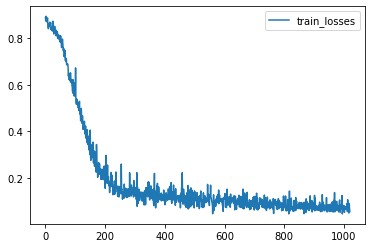

In [37]:
train_split_and_move(6)

In [64]:
!mv *.pth models